In [ ]:
!

In [1]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet


def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.platform: linux
Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
CUDA available: True
numpy_random_seed: 2147483648
GPU 0: Tesla V100-SXM2-32GB
CUDA_HOME: None
GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
PyTorch: 1.12.1+cu116
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.3.2  (built against CUDA 

In [3]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '../../dataset/json/train.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Category ID: 0, Category Name: General trash
Category ID: 1, Category Name: Paper
Category ID: 2, Category Name: Paper pack
Category ID: 3, Category Name: Metal
Category ID: 4, Category Name: Glass
Category ID: 5, Category Name: Plastic
Category ID: 6, Category Name: Styrofoam
Category ID: 7, Category Name: Plastic bag
Category ID: 8, Category Name: Battery
Category ID: 9, Category Name: Clothing


In [ ]:
import wandb
wandb.login()

### CO-DETR

In [4]:
from mmengine import Config
cfg = Config.fromfile('./projects/CO-DETR/configs/codino/co_dino_5scale_r50_lsj_8xb2_1x_coco.py')
# cfg = Config.fromfile('./co_dino_5scale_r50_lsj_8xb2_1x_trash.py')
print(cfg.pretty_text)

auto_scale_lr = dict(base_batch_size=16)
backend_args = None
batch_augments = [
    dict(pad_mask=True, size=(
        1024,
        1024,
    ), type='BatchFixedSizePad'),
]
custom_imports = dict(
    allow_failed_imports=False, imports=[
        'projects.CO-DETR.codetr',
    ])
data_root = 'data/coco/'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(
        _scope_='mmdet',
        by_epoch=True,
        interval=1,
        max_keep_ckpts=3,
        type='CheckpointHook'),
    logger=dict(_scope_='mmdet', interval=50, type='LoggerHook'),
    param_scheduler=dict(_scope_='mmdet', type='ParamSchedulerHook'),
    sampler_seed=dict(_scope_='mmdet', type='DistSamplerSeedHook'),
    timer=dict(_scope_='mmdet', type='IterTimerHook'),
    visualization=dict(_scope_='mmdet', type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
i

In [30]:
from mmengine.runner import set_random_seed

# pre-training weight paths
cfg.load_from = './checkpoints/co_dino_5scale_r50_lsj_8xb2_1x_coco-69a72d67.pth'

# batch size
cfg.train_dataloader.batch_size = 1
# dataloader num workers
cfg.train_dataloader.num_workers = 2

# freezing the layers of the backbone network
cfg.model.backbone.frozen_stages = -1
# number of classifications
cfg.num_classes = 10

# For single card training, you need to change SyncBN to BN
#cfg.norm_cfg = dict(type='BN', requires_grad=True)

# labels and palettes(very important!!)
cfg.metainfo = {
    'classes': ("General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
}

# data folder
cfg.data_root = '../../dataset/splits'

# train json file path
cfg.train_dataloader.dataset.dataset.ann_file = 'train_fold4.json'
cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
# train image file path
cfg.train_dataloader.dataset.dataset.data_prefix.img = ''
cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo

# valid json file path
cfg.val_dataloader.dataset.ann_file = 'val_fold4.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
# valid image file path
cfg.val_dataloader.dataset.data_prefix.img = ''
cfg.val_dataloader.dataset.metainfo = cfg.metainfo


cfg.test_dataloader = cfg.val_dataloader

# valid evaluator json file path
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val_fold4.json'

cfg.test_evaluator = cfg.val_evaluator

# ⭐️ Set the checkpoint interval.
cfg.default_hooks.checkpoint.interval = 4

cfg.device = 'cuda'

# ⭐️ Set the evaluation interval.
#cfg.evaluation.interval = 2


# model weights are saved every 10 intervals, up to two weights are saved at the same time, and the saving strategy is auto
#cfg.default_hooks.checkpoint = dict(type='CheckpointHook', interval=10, max_keep_ckpts=2, save_best='auto')
# Interval of reporting indicators
#cfg.default_hooks.logger.interval = 1

# the ballon dataset is small, so each epoch repeats the data 4 times
#cfg.train_dataloader.dataset = dict(dict(type='RepeatDataset',times=4,dataset=cfg.train_dataloader.dataset.dataset))

# Fixed random number seed
set_random_seed(0, deterministic=False)

cfg.visualizer.vis_backends= [
    dict(type='LocalVisBackend'),
    dict(type='WandbVisBackend'),
]


#------------------------------------------------------
config=f'./co_dino_5scale_r50_lsj_8xb2_1x_trash.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### cascade RCN

In [12]:
from mmengine import Config
cfg = Config.fromfile('./configs/cascade_rcnn/cascade-rcnn_x101_64x4d_fpn_20e_coco.py')
print(cfg.pretty_text)

auto_scale_lr = dict(base_batch_size=16, enable=False)
backend_args = None
data_root = 'data/coco/'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
model = dict(
    backbone=dict(
        base_width=4,
        depth=101,
        frozen_stages=1,
        groups=64,
        init_cfg=dict(
            checkpoint='open-mmlab://resnext101_64x4d', type='Pretrained'),
        norm_cfg=dict(requires_grad=True, type='BN'),
    

In [21]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

data_root = '../../dataset/'
cfg.data_root = data_root

num_classes=10

# labels and palettes(very important!!)
metainfo = {
    'classes': ("General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
}

# dataset config 수정

# model 수정
cfg.model.roi_head.bbox_head[0].num_classes = num_classes
cfg.model.roi_head.bbox_head[1].num_classes = num_classes
cfg.model.roi_head.bbox_head[2].num_classes = num_classes

# train pipeline(load images, augmentation)

color_space = [
    [dict(type='ColorTransform')],
    [dict(type='AutoContrast')],
    [dict(type='Equalize')],
    [dict(type='Sharpness')],
    [dict(type='Posterize')],
    [dict(type='Solarize')],
    [dict(type='Color')],
    [dict(type='Contrast')],
    [dict(type='Brightness')],
]

geometric = [
    [dict(type='Rotate')],
    [dict(type='ShearX')],
    [dict(type='ShearY')],
    [dict(type='TranslateX')],
    [dict(type='TranslateY')],
]

scale = [(1333, 640), (1333, 800)]

# cfg.train_pipeline = [
#     dict(type='RandomResize', scale=scale, keep_ratio=True),
#     dict(type='RandomFlip', prob=0.5),
#     dict(
#         type='RandomOrder',
#         transforms=[
#             dict(type='RandAugment', aug_space=color_space, aug_num=1),
#             dict(type='RandAugment', aug_space=geometric, aug_num=1),
#         ]),
#     dict(type='RandomErasing', n_patches=(1, 5), ratio=(0, 0.2)),
#     dict(type='FilterAnnotations', min_gt_bbox_wh=(1e-2, 1e-2)),
#     dict(
#         type='PackDetInputs',
#         meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
#                    'scale_factor', 'flip', 'flip_direction',
#                    'homography_matrix')),
# ]

# pseudo labeling
cfg.labeled_dataset = dict(
    type='CocoDataset',
    data_root=data_root,
    ann_file='train_sep.json',
    data_prefix=dict(img=''),
    metainfo = cfg.metainfo,
    pipeline=cfg.train_pipeline)

cfg.unlabeled_dataset = dict(
    type='CocoDataset',
    data_root=data_root,
    ann_file='test_pred.json',
    data_prefix=dict(img=''),
    metainfo = cfg.metainfo,
    pipeline=cfg.train_pipeline)

# train_dataloader 수정
cfg.train_dataloader = dict(
    batch_size=4,
    num_workers=8,
    persistent_workers=True,
    dataset=dict(
        type='ConcatDataset', datasets=[cfg.labeled_dataset, cfg.unlabeled_dataset], lazy_init=True))

# val_dataloader 수정
cfg.val_dataloader.dataset.ann_file = 'val_sep.json'
cfg.val_dataloader.dataset.data_prefix = dict(img='')
cfg.val_dataloader.dataset.data_root =  data_root
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader
cfg.test_evaluator = cfg.val_evaluator

# valid evaluator json file path
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val_sep.json'
cfg.val_evaluator.metric = ['bbox']

# ⭐️ Set the checkpoint interval.
cfg.default_hooks.checkpoint.interval = 4

cfg.device = 'cuda'

cfg.load_from = 'https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth'
cfg.visualizer.vis_backends= [
    dict(type='LocalVisBackend'),
    dict(type='WandbVisBackend'),
]

config=f'./cascade-rcnn_x101_64x4d_fpn_20e_trash.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)
#print(cfg.pretty_text)

### Train model

In [22]:
!python tools/train.py {config}

10/14 11:12:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1613198140
    GPU 0: Tesla V100-SXM2-32GB
    CUDA_HOME: None
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-g

### Inference

In [8]:
import os
import pandas as pd
from mmdet.apis import init_detector, inference_detector

# 모델 초기화
epoch = 20
config_file = './cascade-rcnn_x101_64x4d_fpn_20e_trash.py'  # 모델 설정 파일 경로
checkpoint_file = f'./work_dirs/cascade-rcnn_x101_64x4d_fpn_20e_trash/epoch_{epoch}.pth'  # 체크포인트 파일 경로
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# 이미지 경로 및 결과 저장 경로 설정
image_folder = '../../dataset/test'  # 이미지 폴더 경로
output_csv = './output/cascade-rcnn_output_predictions.csv'  # 출력 CSV 파일 경로

# 결과 저장 리스트
results = []

# 이미지 추론
for image_name in os.listdir(image_folder):
    if image_name.endswith(('.jpg', '.png')):  # 지원되는 이미지 형식 확인
        img_path = os.path.join(image_folder, image_name)
        result = inference_detector(model, img_path)

        # DetDataSample에서 결과 추출
        prediction_string = []
        if hasattr(result, 'pred_instances'):
            det_samples = result.pred_instances  # 예측 결과의 인스턴스들
            if det_samples is not None:
                bboxes = det_samples.bboxes
                scores = det_samples.scores
                labels = det_samples.labels

                for j in range(len(bboxes)):
                    prediction_string.append(
                        f"{int(labels[j])} {scores[j]:.4f} {bboxes[j][0]:.2f} {bboxes[j][1]:.2f} {bboxes[j][2]:.2f} {bboxes[j][3]:.2f}"
                    )

        # PredictionString을 먼저 저장하고 image_id는 그 다음에 저장
        results.append({
            'PredictionString': " ".join(prediction_string),  # 한 줄에 저장
            'image_id': f'test/{image_name}'
        })

# 데이터프레임 생성
df = pd.DataFrame(results)

# CSV 파일로 저장
df.to_csv(output_csv, index=False)
df.head()


Loads checkpoint by local backend from path: ./work_dirs/cascade-rcnn_x101_64x4d_fpn_20e_trash/epoch_20.pth


,PredictionString,image_id
0,0 1.0000 0.00 469.98 195.60 590.87 5 0.9965 26...,test/0620.jpg
1,,test/1497.jpg
2,7 0.9998 411.40 387.86 710.21 640.32,test/2643.jpg
3,0 1.0000 353.42 372.82 725.79 809.01,test/3332.jpg
4,0 1.0000 486.85 301.81 928.35 848.49,test/4404.jpg


Available image_ids in submission:
['test/2164.jpg' 'test/0270.jpg' 'test/4234.jpg' ... 'test/2652.jpg'
 'test/2670.jpg' 'test/3200.jpg']


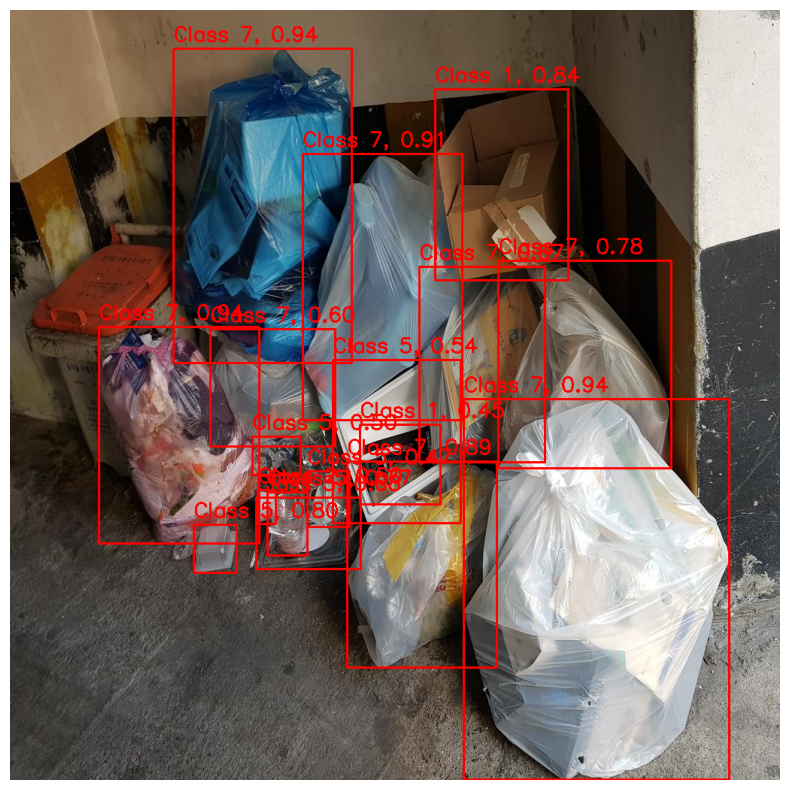

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# CSV 파일 로드
submission_file = os.path.join('./output/vis', f'co-detr-swin-pred.csv')
submission = pd.read_csv(submission_file)

# CSV 파일 내의 image_id 목록 확인 (디버깅 용도)
print("Available image_ids in submission:")
print(submission['image_id'].unique())

# 시각화할 이미지 파일명 설정 (image_id가 'test/0000.jpg' 형식으로 되어 있는 경우)
image_path = '../../dataset/test/0000.jpg'
image_id = 'test/0000.jpg'  # 실제로 저장된 image_id에 맞춰 설정

# 해당 이미지의 PredictionString 가져오기
if image_id not in submission['image_id'].values:
    print(f"Error: image_id '{image_id}' not found in submission CSV file.")
else:
    prediction_string = submission[submission['image_id'] == image_id]['PredictionString'].values[0]

    # PredictionString을 파싱하여 예측 정보 추출 (label, score, xmin, ymin, xmax, ymax)
    predictions = prediction_string.split()

    # 이미지 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 예측된 바운딩 박스를 시각화
    for i in range(0, len(predictions), 6):
        label = int(predictions[i])  # 클래스 라벨
        score = float(predictions[i+1])  # 점수
        if score > 0.4:
            xmin, ymin, xmax, ymax = map(float, predictions[i+2:i+6])  # 좌표를 float으로 변환
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)  # float 값을 int로 변환

            # 바운딩 박스 그리기
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

            # 바운딩 박스 위에 클래스와 점수 표시
            text = f'Class {label}, {score:.2f}'
            cv2.putText(image, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


### predicted csv to json

In [19]:
import pandas as pd
import json
from tqdm import tqdm

# 예측 CSV 파일과 test.json 파일 경로 설정
prediction_csv_path = './output/vis/co-detr-swin-pred.csv'
test_json_path = '../../dataset/test.json'
output_json_path = '../../dataset/test_pred.json'

# 예측 CSV 파일 읽기
predictions_df = pd.read_csv(prediction_csv_path)

# test.json 파일 읽기
with open(test_json_path, 'r') as f:
    test_data = json.load(f)

# 이미지 정보를 담을 리스트
coco_format = {
    "images": [],
    "categories": [
        {"id": 0, "name": "General trash","supercategory": "General trash"},
        {"id": 1, "name": "Paper","supercategory": "Paper"},
        {"id": 2, "name": "Paper pack","supercategory": "Paper pack"},
        {"id": 3, "name": "Metal","supercategory": "Metal"},
        {"id": 4, "name": "Glass","supercategory": "Glass"},
        {"id": 5, "name": "Plastic","supercategory": "Plastic"},
        {"id": 6, "name": "Styrofoam","supercategory": "Styrofoam"},
        {"id": 7, "name": "Plastic bag","supercategory": "Plastic bag"},
        {"id": 8, "name": "Battery","supercategory": "Battery"},
        {"id": 9, "name": "Clothing","supercategory": "Clothing"},
    ],
    "annotations": []
}

# 이미지 파일명과 image_id 매핑을 위한 딕셔너리 생성
image_id_map = {img_info['file_name']: img_info['id'] for img_info in test_data['images']}

# annotation 정보를 생성할 id 변수
annotation_id = 1

# 이미지를 저장할지 여부를 판단하는 딕셔너리 생성 (이미지별로 annotations 여부 확인)
valid_images = {}

# PredictionString을 공백으로 분리하여 각 annotation 정보 추출
for _, row in tqdm(predictions_df.iterrows(), total=len(predictions_df)):
    image_filename = row['image_id']  # CSV에서 image_id가 파일명으로 저장된 경우
    prediction_string = row['PredictionString']
    
    # test.json의 image_id로 변환
    if image_filename in image_id_map:
        image_id = image_id_map[image_filename]
    else:
        continue  # 매칭되는 이미지가 없을 경우 넘어감
    
    # PredictionString을 공백으로 분리하여 annotation 정보 추출
    annotations = prediction_string.split()
    
    # 6개씩 묶어서 label, score, bbox 정보를 가져오기
    for i in range(0, len(annotations), 6):
        if i + 5 < len(annotations):  # 인덱스 범위 체크
            label = int(annotations[i])
            score = float(annotations[i + 1])
            xmin = float(annotations[i + 2])
            ymin = float(annotations[i + 3])
            xmax = float(annotations[i + 4])
            ymax = float(annotations[i + 5])
            
            # COCO 포맷에 맞게 annotation 추가
            if score >= 0.8:
                coco_format['annotations'].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": label,
                    #"score": score,
                    "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],  # [x, y, width, height]
                    "area": (xmax - xmin) * (ymax - ymin),
                    "iscrowd": 0
                })
                annotation_id += 1
                
                # 해당 이미지에 적어도 하나의 유효한 annotation이 있음을 표시
                valid_images[image_id] = True

# test.json에 있는 이미지 중 유효한 annotation이 있는 이미지들만 coco_format['images']에 추가
for img_info in test_data['images']:
    if img_info['id'] in valid_images:
        coco_format['images'].append({
            "id": img_info['id'],
            "file_name": img_info['file_name'],
            "width": img_info['width'],
            "height": img_info['height']
        })

# COCO 포맷 JSON 파일로 저장
with open(output_json_path, 'w') as output_file:
    json.dump(coco_format, output_file, indent=4)

print("COCO 포맷 JSON 파일이 성공적으로 저장되었습니다.")


100%|██████████| 4871/4871 [00:02<00:00, 1927.95it/s]


COCO 포맷 JSON 파일이 성공적으로 저장되었습니다.
